# Create aWhere Grid from Shapefile

## Environment Setup

### Imports

In [1]:
# Imports
import os
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import earthpy as et

### Functions

In [2]:
def create_awhere_grid(study_area_path, buffer_distance, cell_size=0.08):
    """Creates an aWhere-sized grid (0.08 x 0.08 degree,
    5 arc-minute x 5 arc-minute grid) fit to a polygon.

    Parameters
    ----------
    study_area_path : str
        Path the polygon shapefile boundary.

    buffer_distance : int or float
        Buffer size in degrees (WGS 84 CRS).

    cell_size: int or float
        Grid size (x and y dimension) in degrees (WGS 84 CRS).

    Returns
    -------
    study_area_grid_4326: geopandas GeoDataFrame
        Grid dataframe shaped to the polygon boundary.

    Example
    -------
        >>> # Import packages
        >>> import os
        >>> import geopandas as gpd
        >>> # Define path to shapefile boundary
        >>> vt_bound_path = os.path.join(
        ...     working_directory, 'shapefiles', vermont_state_boundary.shp')
        >>> # Create aWhere grid
        >>> vt_grid = create_awhere_grid(vt_bound_path, buffer_distance=0.12)
        >>> # Plot aWhere grid
        >>> vt_grid.plot(facecolor="none", edgecolor="#984ea3", linewidth=1.5)
    """
    # Read shapefile into geodataframe
    study_area = gpd.read_file(study_area_path)

    # Project to WGS 84 Lat/Lon, EPSG 4326 if no CRS match
    if not study_area.crs == 4326:
        study_area_4326 = study_area.to_crs(4326)

    else:
        study_area_4326 = study_area

    # Create buffer around state boundary
    study_area_4326_buffer = study_area_4326.buffer(distance=buffer_distance)

    # Convert buffer from geoseries to geodataframe
    study_area_4326_buffer_gdf = gpd.GeoDataFrame(
        study_area_4326_buffer, crs=4326)

    # Rename geometry column in buffer
    study_area_4326_buffer_gdf.rename(columns={0: 'geometry'}, inplace=True)

    # Get extent of buffered boundary
    longitude_min = study_area_4326_buffer_gdf.bounds.minx[0]
    latitude_min = study_area_4326_buffer_gdf.bounds.miny[0]
    longitude_max = study_area_4326_buffer_gdf.bounds.maxx[0]
    latitude_max = study_area_4326_buffer_gdf.bounds.maxy[0]

    # Create lists for lat/lon extents
    longitude_vals = np.arange(longitude_min, longitude_max, cell_size)
    latitude_vals = np.arange(latitude_min, latitude_max, cell_size)

    # Create grid of polygons based on longitude and latitude ranges
    grid_polys_list = [Polygon([
        (longitude, latitude),
        (longitude + cell_size, latitude),
        (longitude + cell_size, latitude + cell_size),
        (longitude, latitude + cell_size)])
        for longitude in longitude_vals for latitude in latitude_vals]

    # Create geodataframe from grid polygons
    grid_polys_gdf = gpd.GeoDataFrame(crs=4326, geometry=grid_polys_list)

    # Add centroid to each grid cell
    grid_polys_gdf['centroid'] = grid_polys_gdf.geometry.apply(
        lambda poly: poly.centroid)

    # Narrow grid cells to those within the buffered boundary
    study_area_grid_4326 = gpd.sjoin(
        grid_polys_gdf, study_area_4326_buffer_gdf, op='within')
    
    # Drop unnecessary colum
    study_area_grid_4326.drop(columns='index_right', inplace=True)
    
    # Return gridded geodataframe
    return study_area_grid_4326

In [3]:
def extract_centroids(grid):
    """Extracts the longitude and latitude centroids
    from a grid of polygons.
    
    Parameters
    ----------
    grid : geopandas GeoDataFrame
        Grid dataframe with polygon geometry.
    
    Returns
    -------
    centroid_list: list (of tuples)
        List containing (longitude, latitude) tuples.
    
    Example
    -------
        >>> # Extract centroids
        >>> vt_grid_centroids = extract_centroids(vt_grid)
        >>> # Show number of centroids/grid cells
        >>> len(vt_grid_centroids)
        533
        >>> # Show first centroid
        >>> vt_grid_centroids[0]
        (-73.43784136769847, 43.527012318617274)
    """
    # Create copy of dataframe (avoids altering the original)
    grid_extract = grid.copy()
    
    # Extract latitude and longitude to new columns
    grid_extract['longitude'] = grid_extract.centroid.apply(lambda point: point.x)
    grid_extract['latitude'] = grid_extract.centroid.apply(lambda point: point.y)
    
    # Extract centroid (as tuples) from grid
    centroid_list = [(row.longitude, row.latitude) for row in grid_extract.itertuples()]
    
    # Return centroids
    return centroid_list

### File Paths

In [4]:
# Set working directory
working_directory = os.path.join(
    et.io.HOME, 'earth-analytics', 
    '03-geog5663-earth-analytics-applications-summer-2020',
    'git-repos', 'fire-drought-analysis')

In [5]:
# Define path to shapefile
vt_bound_path = os.path.join(
    working_directory, '02-raw-data', 'shapefiles',
    'vermont', 'vermont_state_boundary.shp')

## Create Grid

In [6]:
# Create grid with 0.12-degree buffer (1.5*cell_size) and default cell size
vt_grid = create_awhere_grid(vt_bound_path, buffer_distance=0.12)

In [7]:
# Project state boundary to 4326 (for plotting)
vt_bound_4326 = gpd.read_file(vt_bound_path).to_crs(4326)

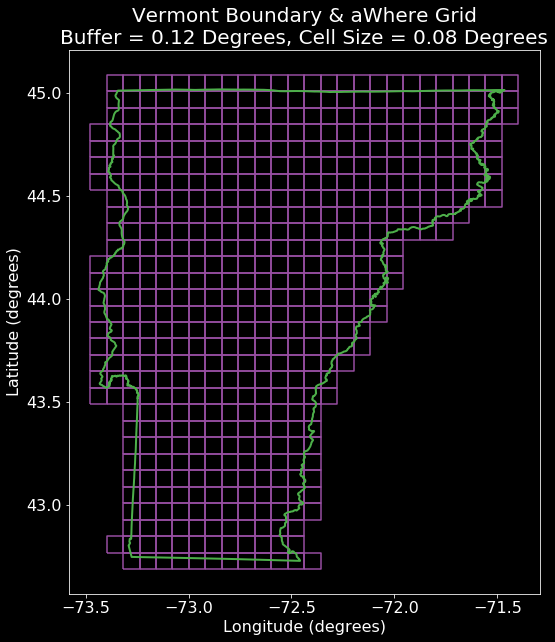

In [8]:
# Plot state boundary (4326) and grid
with plt.style.context('dark_background'):

    fig, ax = plt.subplots(figsize=(20, 10))
    vt_grid.plot(ax=ax, facecolor="none", edgecolor="#984ea3", linewidth=1.5)
    vt_bound_4326.plot(ax=ax, facecolor="none",
                       edgecolor="#4daf4a", linewidth=2)

    ax.set_xlabel("Longitude (degrees)", fontsize=16)
    ax.set_ylabel("Latitude (degrees)", fontsize=16)
    ax.set_title(
        "Vermont Boundary & aWhere Grid\nBuffer = 0.12 Degrees, Cell Size = 0.08 Degrees",
        fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)

    plt.show()

## Extract Grid Centroids

In [9]:
# Extract centroids vrom VT grid to list
vt_grid_centroids = extract_centroids(vt_grid)

In [10]:
# Show number of centroids/grid cells
len(vt_grid_centroids)

533

In [11]:
# Show first 5 centroids
vt_grid_centroids[:5]

[(-73.43784136769847, 43.527012318617274),
 (-73.43784136769847, 43.60701231861727),
 (-73.43784136769847, 43.68701231861726),
 (-73.43784136769847, 43.76701231861726),
 (-73.43784136769847, 43.84701231861727)]

In [12]:
# Show first centroid
vt_grid_centroids[0]

(-73.43784136769847, 43.527012318617274)

In [13]:
# Show first longitude
vt_grid_centroids[:5][0][0]

-73.43784136769847

In [14]:
# Show first latitude
vt_grid_centroids[:5][0][-1]

43.527012318617274

# CA Test

In [15]:
ca_path = os.path.join(
    working_directory, '02-raw-data',
    'california', 'bernardo_box',
    'bernardo_box.shp')

# .to_crs('epsg:4326')
    
#    'ca3300311713320140513',
#    'ca3300311713320140513_20140509_20140525_burn_bndy.shp'

#    'ca3771211950920140815',
#    'ca3771211950920140815_20140726_20150713_burn_bndy.shp'


In [16]:
ca_bound_4326 = gpd.read_file(ca_path).to_crs(4326)

C:\.conda\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [17]:
ca_bound_4326.crs

4326

In [18]:
ca_grid = create_awhere_grid(ca_path, buffer_distance=0.12)

C:\.conda\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [19]:
ca_grid

,geometry,centroid
5,"POLYGON ((-117.23247 32.93937, -117.15247 32.9...",POINT (-117.19247 32.97937)
6,"POLYGON ((-117.23247 33.01937, -117.15247 33.0...",POINT (-117.19247 33.05937)
9,"POLYGON ((-117.15247 32.93937, -117.07247 32.9...",POINT (-117.11247 32.97937)
10,"POLYGON ((-117.15247 33.01937, -117.07247 33.0...",POINT (-117.11247 33.05937)


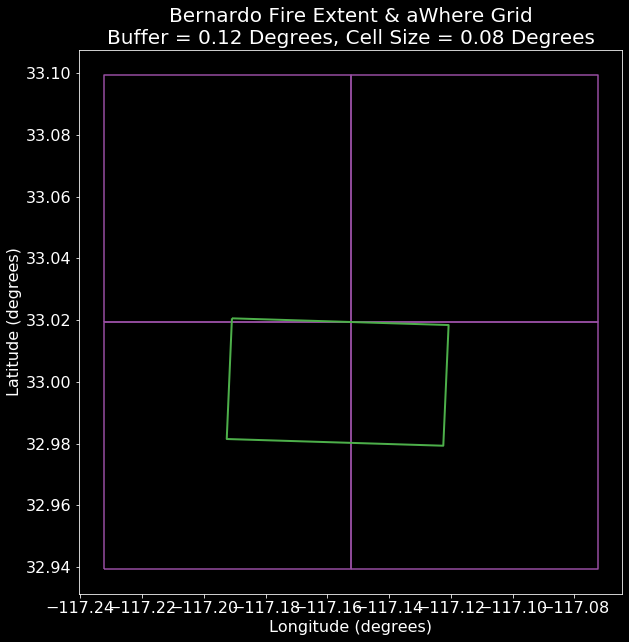

In [20]:
# Plot state boundary (4326) and grid
with plt.style.context('dark_background'):

    fig, ax = plt.subplots(figsize=(20, 10))
    ca_grid.plot(ax=ax, facecolor="none", edgecolor="#984ea3", linewidth=1.5)
    ca_bound_4326.plot(ax=ax, facecolor="none",
                       edgecolor="#4daf4a", linewidth=2)

    ax.set_xlabel("Longitude (degrees)", fontsize=16)
    ax.set_ylabel("Latitude (degrees)", fontsize=16)
    ax.set_title(
        "Bernardo Fire Extent & aWhere Grid\nBuffer = 0.12 Degrees, Cell Size = 0.08 Degrees",
        fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)

    plt.show()

In [21]:
ca_grid_centroids = extract_centroids(ca_grid)

In [22]:
ca_grid_centroids

[(-117.19247200831332, 32.97937160997418),
 (-117.19247200831332, 33.05937160997418),
 (-117.1124720083133, 32.97937160997418),
 (-117.1124720083133, 33.05937160997418)]

In [23]:
from awhere_classes import *

In [24]:
# Show all pandas columns and rows
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

In [25]:
# Define aWhere API key and secret
api_key = os.environ.get('AWHERE_API_KEY')
api_secret = os.environ.get('AWHERE_API_SECRET')

In [26]:
# Get aWhere data
observed = []

for centroid in ca_grid_centroids:

    # Create aWhere weather object
    ca_observed = WeatherLocationObserved(
        api_key, api_secret, latitude=centroid[1], longitude=centroid[0])

    # Convert weather object to gdf
    ca_observed_gdf = WeatherLocationObserved.api_to_gdf(
        ca_observed, kwargs={'start_day': '2014-05-04'}) #, 'end_day': '2014-05-13'})

    observed.append(ca_observed_gdf)

In [27]:
# Get aWhere data
norms = []

for centroid in ca_grid_centroids:

    # Create aWhere weather object
    ca_norms = WeatherLocationNorms(
        api_key, api_secret, latitude=centroid[1], longitude=centroid[0])

    # Convert weather object to gdf
    ca_norms_gdf = WeatherLocationNorms.api_to_gdf(
        ca_norms, kwargs={'start_day': '05-04'}) #, 'end_day': '05-13'})

    norms.append(ca_norms_gdf)

How to best format the geodataframe data with many grid cells in mind? 

Average the data from all grid cell dataframes? With only 4 that makes more sense than if there were more than that? 

Also, how to resample the awhere grid to smaller to match landsat? 

In [28]:
# First grid cell, single day
observed[0]

,temp_max_cels,temp_min_cels,precip_amount_mm,solar_energy_w_h_per_m2,rel_humidity_max_%,rel_humidity_min_%,wind_morning_max_m_per_sec,wind_day_max_m_per_sec,wind_avg_m_per_sec,geometry
date,,,,,,,,,,
2014-05-04,25.799999,12.83,0.0,6592.237305,89.169998,44.560001,4.252426,4.595695,1.993019,POINT (-117.19247 32.97937)


In [29]:
# First grid cell, single day
norms[0]

,mean_temp_avg_cels,mean_temp_std_dev_cels,max_temp_avg_cels,max_temp_std_dev_cels,min_temp_avg_cels,min_temp_std_dev_cels,precip_avg_mm,precip_std_dev_mm,solar_avg_w_h_per_m2,solar.stdDev,min_humiduty_avg_%,min_humidity_std_dev_%,max_humiduty_avg_%,max_humidity_std_dev_%,daily_max_wind_avg_m_per_sec,daily_max_wind_std_dev_m_per_sec,average_wind_m_per_sec,average_wind_std_dev_m_per_sec,geometry
day,,,,,,,,,,,,,,,,,,,
05-04,18.34,1.576598,24.047,3.458082,12.633,1.538174,0.0,0.0,5932.920068,1496.605398,44.925,15.592978,88.041,2.852022,5.749963,1.127736,2.464184,0.684885,POINT (-117.19247 32.97937)


In [30]:
# Difference in max temp, observed - norms, celsius
max_temp_diff = observed[0].temp_max_cels[0] - norms[0].max_temp_avg_cels[0]

In [31]:
# Positive is higher than normal; negative is lower than normal
max_temp_diff

1.7529994964599602

In [32]:
# Difference in avg wind speed, m/s
avg_wind_diff = observed[0].wind_avg_m_per_sec[0] - norms[0].average_wind_m_per_sec[0]

In [33]:
# Positive is higher than normal; negative is lower than normal
avg_wind_diff

-0.47116543054580706

How to best store and index these dataframes?

In [34]:
# Test to see if the data returned from the grids differ
observed[0] == observed[1]

,temp_max_cels,temp_min_cels,precip_amount_mm,solar_energy_w_h_per_m2,rel_humidity_max_%,rel_humidity_min_%,wind_morning_max_m_per_sec,wind_day_max_m_per_sec,wind_avg_m_per_sec,geometry
date,,,,,,,,,,
2014-05-04,False,False,True,False,False,False,False,False,False,False


In [35]:
observed[0] == observed[2]

,temp_max_cels,temp_min_cels,precip_amount_mm,solar_energy_w_h_per_m2,rel_humidity_max_%,rel_humidity_min_%,wind_morning_max_m_per_sec,wind_day_max_m_per_sec,wind_avg_m_per_sec,geometry
date,,,,,,,,,,
2014-05-04,False,False,True,False,False,False,False,False,False,False


In [36]:
observed[0] == observed[3]

,temp_max_cels,temp_min_cels,precip_amount_mm,solar_energy_w_h_per_m2,rel_humidity_max_%,rel_humidity_min_%,wind_morning_max_m_per_sec,wind_day_max_m_per_sec,wind_avg_m_per_sec,geometry
date,,,,,,,,,,
2014-05-04,False,False,True,False,False,False,False,False,False,False


In [37]:
observed[1] == observed[2]

,temp_max_cels,temp_min_cels,precip_amount_mm,solar_energy_w_h_per_m2,rel_humidity_max_%,rel_humidity_min_%,wind_morning_max_m_per_sec,wind_day_max_m_per_sec,wind_avg_m_per_sec,geometry
date,,,,,,,,,,
2014-05-04,False,False,True,False,False,False,False,False,False,False


In [38]:
observed[1] == observed[3]

,temp_max_cels,temp_min_cels,precip_amount_mm,solar_energy_w_h_per_m2,rel_humidity_max_%,rel_humidity_min_%,wind_morning_max_m_per_sec,wind_day_max_m_per_sec,wind_avg_m_per_sec,geometry
date,,,,,,,,,,
2014-05-04,False,False,True,False,False,False,False,False,False,False


In [39]:
observed[2] == observed[3]

,temp_max_cels,temp_min_cels,precip_amount_mm,solar_energy_w_h_per_m2,rel_humidity_max_%,rel_humidity_min_%,wind_morning_max_m_per_sec,wind_day_max_m_per_sec,wind_avg_m_per_sec,geometry
date,,,,,,,,,,
2014-05-04,True,False,True,False,False,False,False,False,False,False


In [40]:
observed[0]

,temp_max_cels,temp_min_cels,precip_amount_mm,solar_energy_w_h_per_m2,rel_humidity_max_%,rel_humidity_min_%,wind_morning_max_m_per_sec,wind_day_max_m_per_sec,wind_avg_m_per_sec,geometry
date,,,,,,,,,,
2014-05-04,25.799999,12.83,0.0,6592.237305,89.169998,44.560001,4.252426,4.595695,1.993019,POINT (-117.19247 32.97937)


In [41]:
observed[1]

,temp_max_cels,temp_min_cels,precip_amount_mm,solar_energy_w_h_per_m2,rel_humidity_max_%,rel_humidity_min_%,wind_morning_max_m_per_sec,wind_day_max_m_per_sec,wind_avg_m_per_sec,geometry
date,,,,,,,,,,
2014-05-04,26.34,12.71,0.0,7329.589355,87.290001,41.389999,4.335209,4.547104,2.05549,POINT (-117.19247 33.05937)


In [42]:
observed[2]

,temp_max_cels,temp_min_cels,precip_amount_mm,solar_energy_w_h_per_m2,rel_humidity_max_%,rel_humidity_min_%,wind_morning_max_m_per_sec,wind_day_max_m_per_sec,wind_avg_m_per_sec,geometry
date,,,,,,,,,,
2014-05-04,25.83,12.31,0.0,6531.062012,86.639999,43.110001,4.288249,4.64844,1.997092,POINT (-117.11247 32.97937)


In [43]:
observed[3]

,temp_max_cels,temp_min_cels,precip_amount_mm,solar_energy_w_h_per_m2,rel_humidity_max_%,rel_humidity_min_%,wind_morning_max_m_per_sec,wind_day_max_m_per_sec,wind_avg_m_per_sec,geometry
date,,,,,,,,,,
2014-05-04,25.83,11.78,0.0,7229.025391,84.610001,40.299999,4.504773,4.763528,2.034595,POINT (-117.11247 33.05937)


https://github.com/aWhereAPI/aWhere-R-Library/blob/master/R/grid-functions.R

Is there a universal grid_id? How is that defined? May have to change the *create_awhere_grid()* function to fit with that? Or define a Python version of the grid?

Universal grid? Does it use UTM? Where does max lon (2160) and lat (1080) come from?

To do:
* Implement parameters/input checks (lat/lon in the correct range, date with correct format, valid api secret and key)
* Add in optional parameters
* Write up about tests within Jupyter Notebook (explanations to complement code)
* Thorough DOCSTRINGS for all functions, to include description, parameters, returns, and examples
* Clean up code in *awhere_classes.py*
* Better the structure for plantings, crops, models (better names for functions and/or inherited functions?)
* Function to load credentials (through different means, OS/Environment variable, from text file, from user account login somehow?)
    * https://github.com/aWhereAPI/aWhere-R-Library/blob/master/R/get-token.R
* Need to incorporate leap year?
    * https://github.com/aWhereAPI/aWhere-R-Library/blob/master/R/utility.R
* Add check within the *create_awhere_grid()* that ensures more than one grid cell? Or does buffer take care of this?
    * DOES THIS (LAT/LON) NEED ANY PADDING? np.floor, np.ceil?
    * OR DOES DUFFER DISTANCE HANDLE THIS?
    * https://github.com/aWhereAPI/aWhere-R-Library/blob/master/R/verify-api-calls.R
* Create full documentation
    * https://github.com/aWhereAPI/aWhere-R-Library/blob/master/documentation/complete-documentation.md
* Use case examples (notebook)
* Write explicit tests for functions/methods (jupyter notebook and .py)
* Convert everything to both .ipynb and .py?
* Plot/visualize data
* Export data to other formats (CSV, for better storage and retrieveal of large datasets?)
* Implement batch processing
* Implement kwargs structure for all functions/methods